Training is completed.<br>
Now test the model and display the results.<br>

In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import logging, os, glob
from _logging import set_logging
from _metrics import display_metrics
from _pckle import save_pickle_object, load_pickle_object
from _utility import gl, get_perc, get_dictionaries_from_list
from _model import train_model

set_logging(logging)
logging.info(f"Cuda is available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ["Business", "Other"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)
test_loader = load_pickle_object(gl.pkl_test_loader)


2023-02-08 16:32:34,306 | INFO : Cuda is available: True
2023-02-08 16:32:34,307 | INFO : Loading pickle file from: pickle\pkle_test_loader.pkl


In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    _mean = [0.5117, 0.4919, 0.4784]
    _std = [0.3312, 0.3193, 0.3272]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(_mean)
    std = np.array(_std)
    inp = std * inp + mean  # denormalise
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
def visualize_model(model, test_loader, classes, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}, actual: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
def get_best_model_from_checkpoint():
    checkpoint_path = os.path.join(gl.chk_dir, gl.chk_resnet_model)
    model_conv = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)
    checkpoint = torch.load(checkpoint_path)
    model_conv.load_state_dict(checkpoint["model_state_dict"])
    model_conv = model_conv.to(device)
    epoch = checkpoint["epoch"]
    accuracy = checkpoint["accuracy"]
    logging.info(f"retreiving the best model from the {epoch} epoch and an accuracy of {accuracy}")
    return model_conv


In [5]:
def test_model(model_conv, test_loader, classes):
    criterion = nn.CrossEntropyLoss()
    running_loss = 0
    running_corrects = 0
    
    all_actuals = torch.tensor((), device=device)
    all_preds = torch.tensor((), device=device)
    # Iterate over data.
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        all_actuals = torch.cat((all_actuals, labels))
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            all_preds = torch.cat((all_preds, preds))

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    dataset_size = len(test_loader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = float(running_corrects) / dataset_size

    logging.info(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    list_actuals = all_actuals.type(torch.int32).tolist()
    list_preds = all_preds.type(torch.int32).tolist()
    display_metrics(list_actuals, list_preds, classes, "Metrics for business/other classification")

2023-02-08 16:32:36,560 | INFO : retreiving the best model from the 5 epoch and an accuracy of 0.7815567222095412


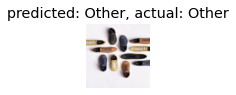

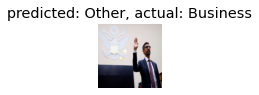

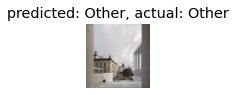

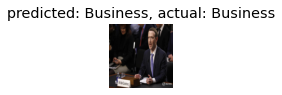

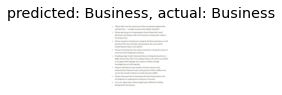

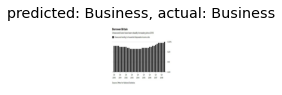

In [6]:
model_conv = get_best_model_from_checkpoint()
visualize_model(model_conv, test_loader, classes)
plt.ioff()
plt.show()


2023-02-08 16:36:09,718 | INFO : Test Loss: 0.4637 Acc: 0.7839


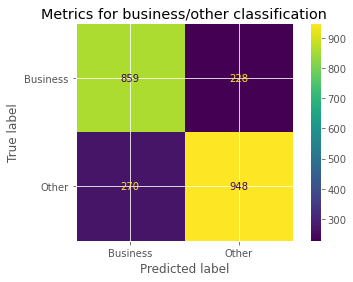

              precision    recall  f1-score   support

    Business       0.76      0.79      0.78      1087
       Other       0.81      0.78      0.79      1218

    accuracy                           0.78      2305
   macro avg       0.78      0.78      0.78      2305
weighted avg       0.78      0.78      0.78      2305



In [7]:
test_model(model_conv, test_loader, classes)

What is noticable about the results is that the false positives and the false negatives are very simialr to each other.
An accuracy of business classification of 0.78 is the best result I can get with this data.